In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import rasterio as rio
from rasterio.crs import CRS

import cv2
from affine import Affine
import numpy as np

from tqdm.notebook import tqdm

Image.MAX_IMAGE_PIXELS = 933120000

In [19]:
# REFERENCE IMAGE FROM QGIS
template = Image.open(r"data\GIS\Harris_full_roadsclipped_dark_full.tiff")
# template = Image.open(r"data\GIS\template_cropped.png")

# TILE INDEX TO TEST ON
test_index = Image.open(r"data\000_WorkingFiles\HarrisIndexes\48201CIND0_0992.tif")

def bomb_sides(image, n, replacement_value):
    result = np.copy(image)
    rows, cols = image.shape

    # Replace values in the left and right columns
    result[:, :n] = replacement_value
    result[:, -n:] = replacement_value

    # Replace values in the top and bottom rows
    result[:n, :] = replacement_value
    result[-n:, :] = replacement_value

    return result

def preprocess_image_good(image):
    image = np.asarray(image) * 255
    image = image.astype(np.uint8)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = np.where(image < 150, image, 255).astype(np.uint8)
    # image = cv2.dilate(image, np.ones((3,3), np.uint8), iterations=1)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=2)
    image = np.where(image < 150, image, 255).astype(np.uint8)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=2)
    image = np.where(image < 50, 0, 255).astype(np.uint8)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=5)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = 255 - image
    return image

def preprocess_image_good(image):
    image = np.asarray(image) * 255
    image = image.astype(np.uint8)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = np.where(image < 150, image, 255).astype(np.uint8)
    image = cv2.dilate(image, np.ones((3,3), np.uint8), iterations=1)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=2)
    image = np.where(image < 150, image, 255).astype(np.uint8)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=2)
    image = np.where(image < 50, 0, 255).astype(np.uint8)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=5)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = 255 - image
    return image

def preprocess_image_working(image):
    image = np.asarray(image) * 255
    image = bomb_sides(image, 255, 500)
    image = image.astype(np.uint8)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=10)
    image = cv2.GaussianBlur(image, (31, 31), 0)
    image = 255 - image
    return image

def preprocess_template(template):
    template = np.asarray(template).astype(np.uint8)
    template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    # template = cv2.GaussianBlur(template, (11, 11), 0)
    # template = 255 * template / np.max(template)
    template = template.astype(np.uint8)
    template = 255 - template
    return template

template = preprocess_template(template)
test_preprocess = preprocess_image_good(test_index)
Image.fromarray(template).save("template.png")
Image.fromarray(test_preprocess).save("test.png")

In [ ]:
with ThreadPoolExecutor(max_workers=10) as executor:
    for i in tqdm(executor.map(PrepareDataset, image_list), total=len(image_list))

In [32]:
# Define the range of rescaling factors and rotation angles
rescale_factors = np.arange(0.85, .91, 0.01)
rotation_angles = [0]

# Initialize a list to store the matches
all_matches = []

# Initialize variables to store the best match
best_match_scale = 1.0
best_match_angle = 0.0

opt_max = False

if opt_max:
    best_match_value = -1 * np.inf
else:
    best_match_value = np.inf

result_list = list()
best_loc_list = list()
rect_corner_list = list()
# Iterate over the rescaling factors and rotation angles
for scale in tqdm(rescale_factors):
    for angle in rotation_angles:
        # Resize the template based on the current scale
        scaled_template = cv2.resize(template, None, fx=scale, fy=scale)

        # Rotate the template based on the current angle
        rotation_matrix = cv2.getRotationMatrix2D((scaled_template.shape[1] / 2, scaled_template.shape[0] / 2), angle, 1.0)
        rotated_template = cv2.warpAffine(scaled_template, rotation_matrix, (scaled_template.shape[1], scaled_template.shape[0]))
        
        mask = np.where(rotated_template == 0, 0, 255).astype(np.uint8)
        # Image.fromarray(rotated_template).save(f"templates/{scale:.2f}_{angle}.png")
        # Image.fromarray(mask).save(f"templates/{scale:.2f}_{angle}_mask.png")
        
        #fig, axs = plt.subplots(1,3, figsize=(10,5))
        #axs[0].hist(template_gray.flatten())
        #axs[1].hist(main_image_gray.flatten())
        #axs[2].hist(mask.flatten())
        
        # plt.show()

        # Perform template matching
        result = cv2.matchTemplate(test_preprocess, rotated_template, cv2.TM_SQDIFF, mask=mask)
        # result = cv2.matchTemplate(test_preprocess, rotated_template, cv2.TM_CCORR_NORMED, mask=mask)
        
        
        if not opt_max:
            result = np.sqrt(result / np.count_nonzero(mask))
            
        
        result_list.append(result)
        
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        
        if opt_max:
            best_val = max_val
            best_loc = max_loc
            bottom_right = (best_loc[0] + int(rotated_template.shape[1]), best_loc[1] + int(rotated_template.shape[0]))
            
            best_loc_list.append(best_loc)
            rect_corner_list.append(bottom_right)
            
            # Update the best match if the current match is better
            if best_val > best_match_value:
                best_match_value = best_val
                best_match_scale = scale
                best_match_angle = angle
                best_match_loc   = best_loc
                best_match_br    = bottom_right
            
        else:
            best_val = min_val
            best_loc = min_loc
            bottom_right = (best_loc[0] + int(rotated_template.shape[1]), best_loc[1] + int(rotated_template.shape[0]))
            best_loc_list.append(best_loc)
            rect_corner_list.append(bottom_right)
            # Update the best match if the current match is better
            if best_val < best_match_value:
                best_match_value = best_val
                best_match_scale = scale
                best_match_angle = angle
                best_match_loc   = best_loc
                best_match_br    = bottom_right
            
        
        print(scale, angle, best_val)
        
        
        
       

  0%|          | 0/7 [00:00<?, ?it/s]

0.85 0 127.04201236836995
0.86 0 126.94744542159758
0.87 0 126.94240741614793
0.88 0 127.0170686967541
0.89 0 127.06996248692644
0.9 0 127.13275329192847
0.91 0 127.36832672063977


In [33]:
elem_list = [x.flatten() for x in result_list]
elem_list = np.hstack(elem_list)

if opt_max:
    thresh = np.percentile(elem_list, 99.9)
    loc_list = [x > thresh for x in result_list]
else:
    thresh = np.percentile(elem_list, 0.1)
    loc_list = [x < thresh for x in result_list]

votes = np.array([np.count_nonzero(x) for x in loc_list])
rescale_factor = np.sum(votes * rescale_factors) / np.sum(votes)

x_list = np.hstack([np.where(x)[0] for x in loc_list])
y_list = np.hstack([np.where(x)[1] for x in loc_list])

x = int(np.median(x_list))
y = int(np.median(y_list))

br = (int(y + template.shape[1] * rescale_factor), int(x + template.shape[0] * rescale_factor))

In [34]:
three_band = np.dstack([test_preprocess,test_preprocess,test_preprocess])
print(three_band.shape)

# Draw rectangles around the matched regions for each scale
for i in range(len(best_loc_list)):
    top_left = best_loc_list[i]
    bottom_right = rect_corner_list[i]
    cv2.rectangle(three_band, top_left, bottom_right, (255, 0, 0), 10)
    
_ = cv2.rectangle(three_band, best_match_loc, best_match_br, (0, 0, 255), 5)
_ = cv2.rectangle(three_band, (y, x), br, (0, 255, 0), 5)

(10200, 14840, 3)


In [37]:
rescale_factor

0.8663110626589835

In [35]:
cv2.imwrite('testout.png', three_band)

True

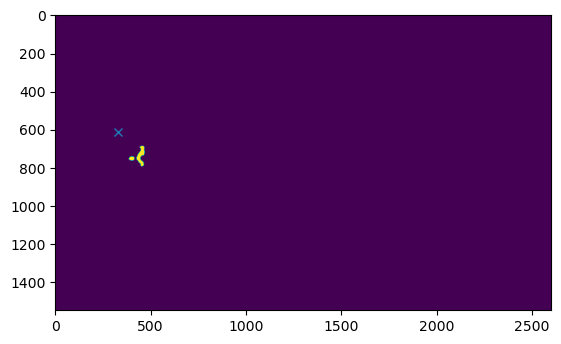

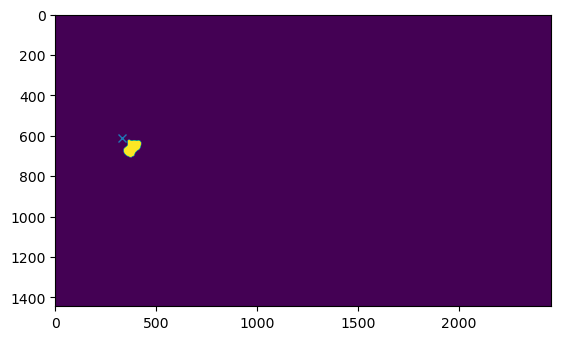

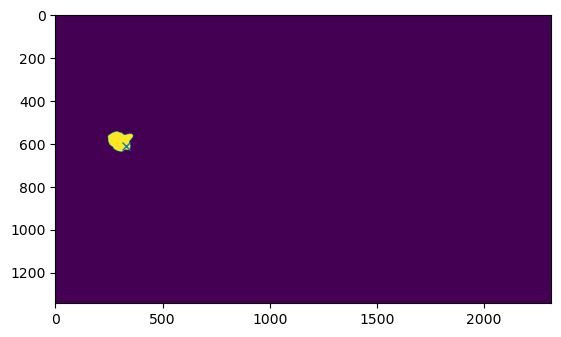

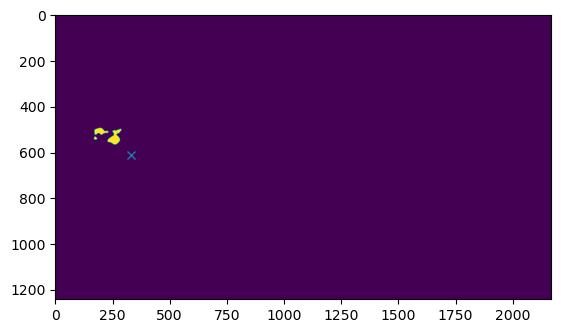

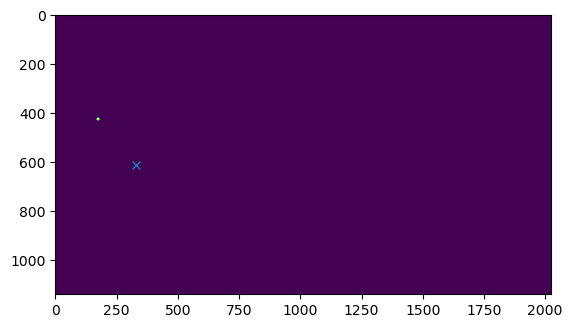

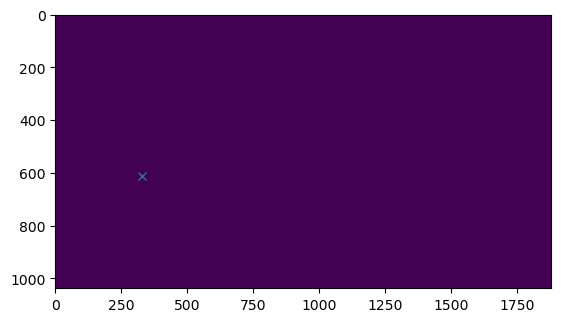

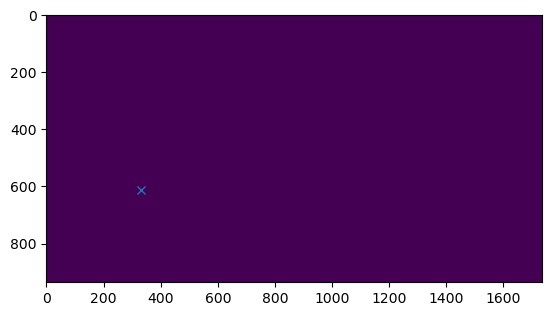

In [36]:
for i in loc_list:
    fig, ax = plt.subplots()
    ax.imshow(i)
    ax.plot(y, x, 'x')
    plt.show()